<a href="https://colab.research.google.com/github/Alton01/LSTM_AMZN_Stock_Forecast/blob/main/LSTM_AMZN_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [2]:
data = data[['Date', 'Close']]

data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

/tmp/ipython-input-4-1089395781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


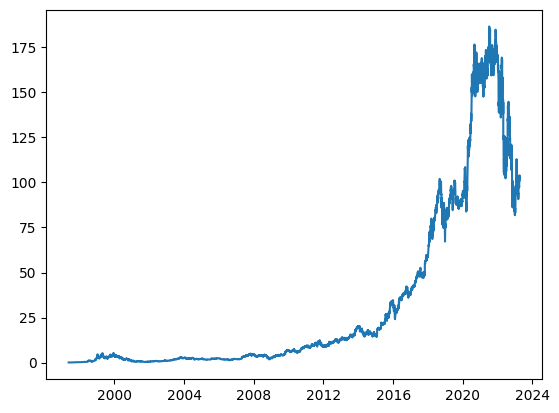

In [4]:
# convert date to pandas datetime object
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
# For calculating stock price closing value from previous day down to a week earlier.

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)

  for i in range(1, n_steps + 1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)

shifted_df


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [6]:
# convert dataframe to numpy

shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [7]:
# The scaling is done to transform the data to a range between -1 and 1, which is often beneficial for training neural networks.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [8]:
# X for selecting all the rows and selecting from the 1st column onwards
# y for selecting all the rows and selecting prior to the 1st column
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [9]:
# flipping the numpy data array as t-7 is supposed to be closer to current closing price while t-1 is  furthest

X = dc(np.flip(X, axis=1))

X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [10]:
split_index = int(len(X) * 0.95)

split_index

6183

In [11]:
# Split dataset into training and testing dataset

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [12]:
# The X arrays are reshaped into a 3D format (-1, lookback, 1), which is a common requirement for LSTM layers in neural networks.
# The -1 infers the number of samples, lookback is the number of time steps (7 in this case),
# And 1 is the number of features (the closing price).
# The y arrays are reshaped into a 2D format (-1, 1) to match the expected output shape for training.
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [13]:
# convert numpy data to tesnors as we are making use of pytorch

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).float()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [14]:
# For loading data into dataset

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)


In [15]:
len(train_dataset), len(test_dataset)

(6183, 326)

In [16]:
len(X_train), len(X_test)

(6183, 326)

In [17]:
# Batchifying datasets into dataloaders

from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# enumerate is used to get both the index and the batch.
# The underscore _ indicates that we don't need the index in this case.
for _, batch in enumerate(train_loader):
  # unpacks batch into features and targets
  X_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(X_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
# Model creation
# num_stacked_layers: The number of recurrent layers.

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    # h0 and c0: These are the initial hidden and cell states of the LSTM, initialized to zeros.
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    #  This passes the input x and the initial states through the LSTM layer. The output out contains the hidden states for each time step.
    out, _ = self.lstm(x, (h0, c0))
    # This selects the hidden state from the last time step (out[:, -1, :]) and passes it through the fully connected layer to get the final outpu
    out = self.fc(out[:, -1, :])
    return out

# This creates an instance of the LSTM model with an input size of 1, a hidden size of 4, and 1 stacked layer.
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
  model.train()
  print(f"Epoch: {epoch + 1}")
  running_loss = 0

  for batch_index, batch in enumerate(train_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    output = model(X_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
      running_loss = 0.0



In [21]:
def validate_one_epoch():
  model.eval()
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        output = model(X_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)
  print('Validation Loss: {0:.3f}'.format(avg_loss_across_batches))
  print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.848
Batch 200, Loss: 0.379
Batch 300, Loss: 0.199
Validation Loss: 0.852

Epoch: 2
Batch 100, Loss: 0.152
Batch 200, Loss: 0.157
Batch 300, Loss: 0.110
Validation Loss: 0.382

Epoch: 3
Batch 100, Loss: 0.064
Batch 200, Loss: 0.045
Batch 300, Loss: 0.026
Validation Loss: 0.070

Epoch: 4
Batch 100, Loss: 0.019
Batch 200, Loss: 0.013
Batch 300, Loss: 0.014
Validation Loss: 0.031

Epoch: 5
Batch 100, Loss: 0.009
Batch 200, Loss: 0.006
Batch 300, Loss: 0.006
Validation Loss: 0.017

Epoch: 6
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002
Validation Loss: 0.011

Epoch: 7
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Validation Loss: 0.006

Epoch: 8
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Validation Loss: 0.005

Epoch: 9
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Validation Loss: 0.004

Epoch: 10
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Val